# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import ParameterGrid, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
xscaler = MinMaxScaler()

In [2]:
file_path = '../../input_data/pspeo_master.xlsx'
model_output = 'fwhm'
# import data frame for pre-processing
df = pd.read_excel(file_path)
df.head()

,sample,solv_ratio,add_type,swell_ratio,gisaxs_domain,gisaxs_fwhm,afm_domain,afm_grain
0,I_A_AC,80/20,Chloronaphthalene,1.00,31.302630,0.003697,33.737303,0.0048
1,I_A025,80/20,Chloronaphthalene,1.25,33.805848,0.003136,35.151690,0.0047
2,I_A050,80/20,Chloronaphthalene,1.50,34.176062,0.002970,35.397797,0.0534
3,I_A075,80/20,Chloronaphthalene,1.75,34.383751,0.003451,34.603726,0.0425
4,I_A_100,80/20,Chloronaphthalene,2.00,31.674148,0.005122,33.786210,0.0244


# Data pre-processing

In [3]:
# Assign input variables and target variable, eliminating static valuesp
inputs = df.loc[:, ['solv_ratio', 'swell_ratio', 'add_type']]
target = df['gisaxs_fwhm']

# Define mapping for solv_ratio
type_mapping = {100: 1.0, '90/10': 0.9, '80/20': 0.8, '70/30': 0.7, '60/40': 0.6, '50/50': 0.5}
inputs['solv_ratio'] = inputs['solv_ratio'].replace(type_mapping)

# Encode categorical input 'add_type'
le_addType = LabelEncoder()
inputs['add_type'] = le_addType.fit_transform(inputs['add_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

# Grid-Search

In [4]:
%%time

# Define parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [0, 0.5, 1],
    'n_estimators': [100, 150, 200],
    'objective': ['reg:squarederror'],
    'eval_metric': ['rmse']
}


# Set seed
RANDOM_SEED = 42
CV_FOLDS = 5

# Variables to store the best results
best_model = None
best_params = None
best_avg_r2 = float('-inf')

# Loop over all combinations
for params in ParameterGrid(param_grid):
    model = XGBRegressor(**params, random_state=RANDOM_SEED, n_jobs=-1)
    
    # Cross-validated R² on training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=CV_FOLDS, scoring='r2', n_jobs=-1)
    cv_r2 = np.mean(cv_scores)
    
    # Fit model to full training set
    model.fit(X_train, y_train)
    
    # R² on test set
    test_r2 = model.score(X_test, y_test)
    
    # Average R²: cross-val on train + test
    avg_r2 = (cv_r2 + test_r2) / 2

    if avg_r2 > best_avg_r2:
        best_avg_r2 = avg_r2
        best_model = model
        best_params = params
        best_cv_r2 = cv_r2
        best_test_r2 = test_r2

# Output the results
print("Best Average R² (CV Train + Test):", best_avg_r2)
print("CV Train R²:", best_cv_r2)
print("Test R²:", best_test_r2)
print("Best Parameters:", best_params)

Best Average R² (CV Train + Test): 0.6382304798913625
CV Train R²: 0.5849692708746959
Test R²: 0.6914916889080291
Best Parameters: {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
CPU times: user 2min 7s, sys: 2min 23s, total: 4min 30s
Wall time: 1min 29s


In [5]:
best = XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best.fit(X_train, y_train)
# test_r2 = model.score(X_test, y_test)  # or use r2_score(y_test, model.predict(X_test))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [6]:
train_r2 = best.score(X_train, y_train)
test_r2 = best.score(X_test, y_test)

print(f'Training r2: {train_r2}')
print(f'Testing r2: {test_r2}')

# Create an array for x values
x_len = len(y_test)
actual_x = np.arange(1, x_len+1)

# Define the output path for figures
output_path = f'../final_figs/{model_output}/'

Training r2: 0.7381157774893665
Testing r2: 0.6914916889080291


In [7]:
from joblib import dump, load

dump(best, f'{model_output}.joblib')

['fwhm.joblib']

In [8]:
xgb_train = best.predict(X_train)
xgb_test = best.predict(X_test)

# Visualize the results

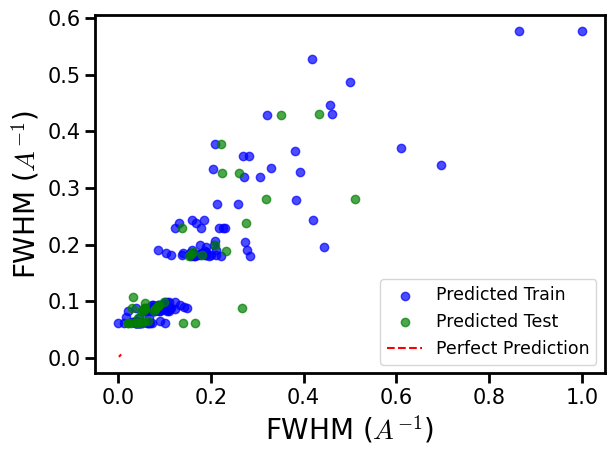

In [13]:
# Define the figure title
fig_title = f'{model_output}_avp.png'

# set formatting for plots
%matplotlib inline
# from matplotlib import cm
from matplotlib import rc
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   

# Create a scatter plot
plt.scatter(y_train, xgb_train, color='blue', label='Predicted Train', alpha=0.7)
plt.scatter(y_test, xgb_test, color='green', label='Predicted Test', alpha=0.7)

# Add a diagonal line for reference (perfect prediction)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='red', label='Perfect Prediction')

# Add labels and a legend
plt.xlabel('FWHM ($A^{-1}$)', fontsize='20')
plt.ylabel('FWHM ($A^{-1}$)', fontsize='20')

# Set legend background color to white
legend = plt.legend(fontsize='12.5')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

# Show the plot
plt.tight_layout()
# plt.savefig(output_path + fig_title, format='png')
plt.show()

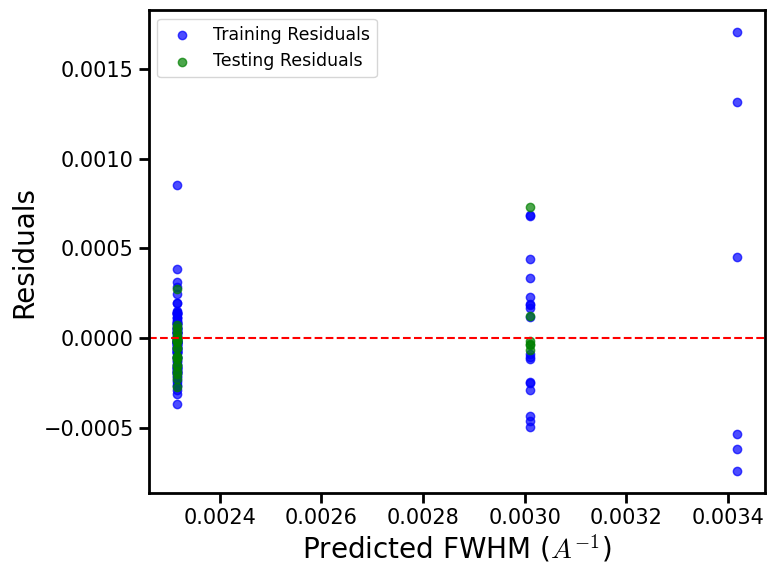

In [8]:
# Define the figure title
fig_title = f'{model_output}_residuals.png'

res_train = y_train - xgbtrain
res_test = y_test - xgbeval

# set formatting for plots
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(xgbtrain, res_train, color='blue', alpha=0.7, label='Training Residuals')
plt.scatter(xgbeval, res_test, color='green', alpha=0.7, label='Testing Residuals')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted FWHM ($A^{-1}$)", fontsize='20')
plt.ylabel("Residuals", fontsize='20')
# Set legend background color to white
legend = plt.legend(fontsize='12.5')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.grid(False)
plt.tight_layout()
plt.savefig(output_path + fig_title, format='png')
plt.show()

In [9]:
from joblib import dump, load

dump(best, 'xgb_fwhm.joblib')

['xgb_fwhm.joblib']